In [1]:
!pip uninstall --yes opencv-contrib-python opencv-python
!pip install opencv-contrib-python

Found existing installation: opencv-contrib-python 4.5.4.60
Uninstalling opencv-contrib-python-4.5.4.60:
  Successfully uninstalled opencv-contrib-python-4.5.4.60
Found existing installation: opencv-python 4.5.4.60
Uninstalling opencv-python-4.5.4.60:
  Successfully uninstalled opencv-python-4.5.4.60
     |████████████████████████████████| 66.5 MB 35.4 MB/s            


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import random
import warnings
from bs4 import BeautifulSoup
warnings.filterwarnings("ignore")

In [3]:
# Define Directory 
images_directory = "../input/simple-object-detection/datasets/images"
annotations_directory="../input/simple-object-detection/datasets/annotations"

#Read Directory

img_paths = sorted([os.path.join(fname) for fname in os.listdir(images_directory) if fname.endswith(".jpg")])
label_paths = sorted([os.path.join(annotations_directory, fname) for fname in os.listdir(annotations_directory) if fname.endswith(".xml")])

k = len(img_paths)

data_list = []

#Generate Data Frame 

for i in range(k):  
    annotation_file=label_paths[i]
    ds = BeautifulSoup(open(annotation_file).read(), "html.parser")

    # Iterating over each object elements
    for o in ds.find_all("object"):
        
        x_min = max(0, int(float(o.find("xmin").string)))
        y_min = max(0, int(float(o.find("ymin").string)))
        x_max = min(int(ds.find("width").string), int(float(o.find("xmax").string)))
        y_max = min(int(ds.find("height").string), int(float(o.find("ymax").string)))
        
        # in case the boundary goes above its limis, providing some restrictions.
        if x_min >= x_max or y_min >= y_max:
            continue
        elif x_max <= x_min or y_max <= y_min:
            continue
        
        sample = [str(img_paths[i]), x_min, y_min, x_max, y_max]
        
        data_list.append(sample)
        
data = pd.DataFrame(data_list)

In [4]:
#Rename Columns
data = data.rename(columns={0: 'Name',1:'x1',2:'y1',3:'x2',4:'y2'})

In [5]:
data

,Name,x1,y1,x2,y2
0,a (1).jpg,38,54,179,173
1,a (10).jpg,58,14,155,117
2,a (100).jpg,86,18,182,125
3,a (101).jpg,23,16,120,115
4,a (102).jpg,33,30,166,173
...,...,...,...,...,...
107,a (95).jpg,55,118,157,219
108,a (96).jpg,98,105,214,224
109,a (97).jpg,100,88,213,205
110,a (98).jpg,88,44,207,171


Photo shape: (224, 224, 3)
Name,xmin,ymin,xmax,ymax: ['a (1).jpg' 38 54 179 173]


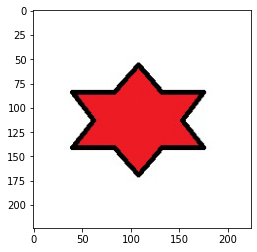

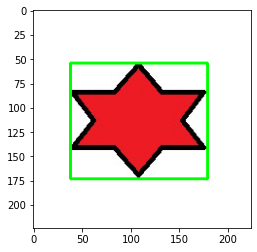

In [6]:
#Show One Image 
for i in data.values:
  photo=plt.imread(f'../input/simple-object-detection/datasets/images/{i[0]}')
  plt.imshow(photo)
  print('Photo shape:',photo.shape)
  print('Name,xmin,ymin,xmax,ymax:',i)
  pt1=(int(i[1]),int(i[2]))
  pt2=(int(i[3]),int(i[4]))
  color=(0, 255, 0)
  thickness = 2
  #draw rectangle 
  cv2.rectangle(photo,pt1,pt2, color, thickness)
  plt.figure()
  plt.imshow(photo)
  #break for
  break

(224, 224, 3)
(224, 224, 3)


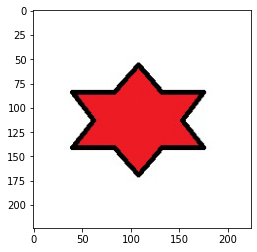

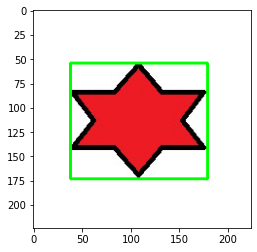

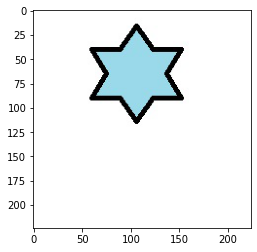

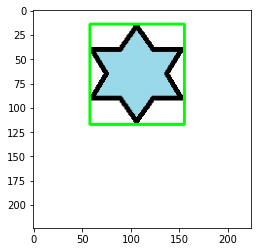

In [7]:
#Show x Images
for a,i in enumerate(data.values):
  img=plt.imread('../input/simple-object-detection/datasets/images/'+i[0])
  print(img.shape)
  plt.figure()
  plt.imshow(img)
  xmin=int(i[1])
  ymin=int(i[2])
  xmax=int(i[3])
  ymax=int(i[4])
  cv2.rectangle(img,(xmin, ymin),(xmax, ymax),(0, 255, 0),2)
  plt.figure()
  plt.imshow(img)
  # a = image numbers
  if a ==1:
    break

In [8]:
cv2.setUseOptimized(True) # Optimeze
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() # Selective search obje

Shape: (224, 224, 3)
possible bounty boxes: 198


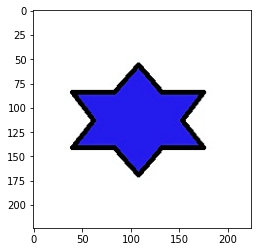

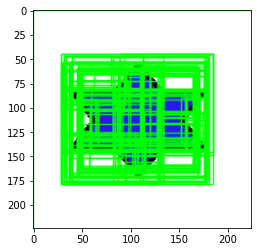

In [9]:
im = cv2.imread('../input/simple-object-detection/datasets/images/a (1).jpg')
im=cv2.resize(im,(224,224))
plt.figure()
plt.imshow(im)
ss.setBaseImage(im) # The part where the image is loaded.  
ss.switchToSelectiveSearchFast() #To speed up the selective search time 
rects = ss.process()
print('Shape:',im.shape)
print('possible bounty boxes:',len(rects)) #possible bounty boxes 

for rect in rects:
  x, y, w, h = rect
  imOut=cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imOut);

In [10]:
#Iou and selective search 
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
def get_iou(bb1, bb2):
    #eliminate errors 
    assert bb1['x1'] < bb1['x2'] #bb1
    assert bb1['y1'] < bb1['y2']

    assert bb2['x1'] < bb2['x2'] #bb2
    assert bb2['y1'] < bb2['y2'];

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
      return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    #remove highs and lows 
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [11]:
image_liste=[]
k=0
l=0
z=0 #Loading
for a in data.values:
  Name,xmin,ymin,xmax,ymax=a
  bb1={ #boxxes
            'x1':int(xmin),
            'y1':int(ymin),
            'x2':int(xmax),
            'y2':int(ymax)
            }
  try:
    img=cv2.imread('../input/simple-object-detection/datasets/images/'+Name)
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    for i in rects:
      x, y, w, h = i # Selective bounty boxxes
      bb2={'x1':x, 
          'y1':y,
          'x2':x+w,
          'y2':y+h
          }
      img1=img[bb2['y1']:bb2['y2'],bb2['x1']:bb2['x2']] # Crop img
      img1_shape=cv2.resize(img1,(224,224))
      if k<l:
            if 0.5<get_iou(bb1,bb2):  
              image_liste.append([img1_shape,1])
              k+=1
      else:
        if 0.5<get_iou(bb1,bb2):  
          image_liste.append([img1_shape,1])
          k+=1
        else:
          image_liste.append([img1_shape,0])
          l+=1
  except Exception as e:
    print('hata var',e)
  z+=1
  #print(Name,z,len(rects))

In [12]:
len(image_liste)

9575

In [13]:
data=[]
data_label=[]
for features,label in image_liste:
  data.append(features)
  data_label.append(label)
print('transaction successful ')

transaction successful 


In [14]:

print(data_label[0:5])

[0, 1, 0, 1, 1]


In [15]:
print('Number of photos :',len(data),'Label number :',len(data_label))

Number of photos : 9575 Label number : 9575


Class: 1
Image size : (224, 224, 3)


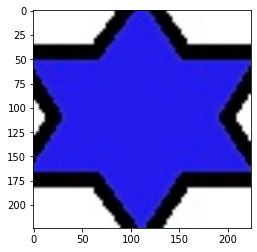

In [16]:
i=random.randint(1,10583-1)
print('Class:',data_label[i])
print('Image size :',data[i].shape)
plt.imshow(data[i]);

In [17]:
data=np.asarray(data)
data_label=np.asarray(data_label) 

In [18]:
print('Not image :',len(data_label[data_label==0]),'|There is a image :',len(data_label[data_label==1]))

Not image : 4784 |There is a image : 4791


In [19]:
data.shape

(9575, 224, 224, 3)

In [20]:
data_label.shape

(9575,)

In [21]:
#Generate Train and val
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(data,data_label,test_size=0.33, random_state=42)

In [22]:
print('x_train shape:',x_train.shape)
print('x_val shape:',x_val.shape)
print('y_train shape:',y_train.shape)
print('y_val shape:',y_val.shape)

x_train shape: (6415, 224, 224, 3)
x_val shape: (3160, 224, 224, 3)
y_train shape: (6415,)
y_val shape: (3160,)


In [23]:
base_model=tf.keras.applications.VGG16(include_top=False,input_shape=(224,224,3),weights='imagenet')

2021-12-17 21:28:15.517941: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 21:28:15.608312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 21:28:15.609012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 21:28:15.610087: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [24]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [25]:
model=tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
#Detectate image or not image 
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________


In [27]:
base_model.trainable=False

In [28]:
for i,layer in enumerate(base_model.layers):
  print(i,layer.name,'-',layer.trainable)

0 input_1 - False
1 block1_conv1 - False
2 block1_conv2 - False
3 block1_pool - False
4 block2_conv1 - False
5 block2_conv2 - False
6 block2_pool - False
7 block3_conv1 - False
8 block3_conv2 - False
9 block3_conv3 - False
10 block3_pool - False
11 block4_conv1 - False
12 block4_conv2 - False
13 block4_conv3 - False
14 block4_pool - False
15 block5_conv1 - False
16 block5_conv2 - False
17 block5_conv3 - False
18 block5_pool - False


In [29]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics='accuracy')

In [30]:
epoch=4
#In  x_train and y_train enter cut image 
hist=model.fit(x_train,y_train,epochs=epoch,validation_data=(x_val,y_val))

2021-12-17 21:28:19.351877: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 965637120 exceeds 10% of free system memory.
2021-12-17 21:28:20.435383: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 965637120 exceeds 10% of free system memory.
2021-12-17 21:28:21.347265: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/4


2021-12-17 21:28:22.752602: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


201/201 [==============================] - ETA: 0s - loss: 0.7693 - accuracy: 0.7994

2021-12-17 21:28:44.304236: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 475668480 exceeds 10% of free system memory.
2021-12-17 21:28:44.793271: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 475668480 exceeds 10% of free system memory.


201/201 [==============================] - 32s 112ms/step - loss: 0.7693 - accuracy: 0.7994 - val_loss: 0.1336 - val_accuracy: 0.9465
Epoch 2/4
201/201 [==============================] - 18s 88ms/step - loss: 0.1967 - accuracy: 0.9272 - val_loss: 0.0899 - val_accuracy: 0.9649
Epoch 3/4
201/201 [==============================] - 18s 88ms/step - loss: 0.1439 - accuracy: 0.9442 - val_loss: 0.0911 - val_accuracy: 0.9642
Epoch 4/4
201/201 [==============================] - 18s 88ms/step - loss: 0.1341 - accuracy: 0.9532 - val_loss: 0.0746 - val_accuracy: 0.9715


Number of possible objects in the photo:  120
how many possible bounty boxes with a class prediction of 1 are there : 37
-------------------------------------------------------------------------


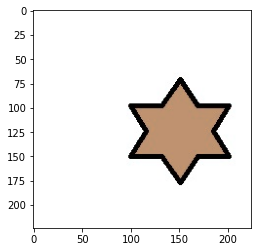

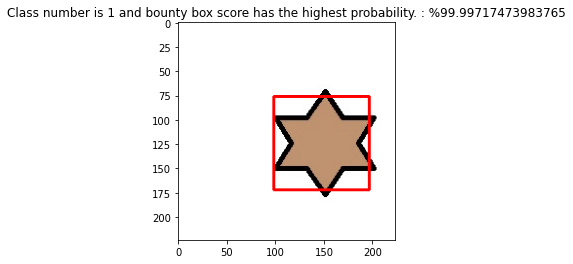

In [31]:
Myobject=[]
photo_path='../input/simple-object-detection/datasets/images/a (23).jpg'
deneme_img=cv2.imread(photo_path)
ss.setBaseImage(deneme_img)
ss.switchToSelectiveSearchFast()
rects1 = ss.process()

print('Number of possible objects in the photo: ',len(rects1))
for i in rects1:
  x, y, w, h = i
  bb3={'x1':x,
        'y1':y,
        'x2':x+w,
        'y2':y+h
      }
  try:
    #Eliminate errors
    assert bb3['x1'] < bb3['x2']
    assert bb3['y1'] < bb3['y2']
    
    #images without errors 
    img_data=deneme_img[bb3['y1']:bb3['y2'],bb3['x1']:bb3['x2']]
    img_data=cv2.resize(img_data,(224,224))
    tahmin=model.predict(img_data.reshape(1,224,224,3))
    
    #good images 
    if tahmin[0]>0.5:
      Myobject.append([bb3,tahmin[0]])
    else:
      pass
  except Exception as e:
    print('hata',e)
print('how many possible bounty boxes with a class prediction of 1 are there :',len(Myobject))
print('-------------------------------------------------------------------------')
deneme_img=cv2.imread(photo_path)
Myobject[np.argmax(np.array(Myobject)[:,1])][0]
pt1=(Myobject[np.argmax(np.array(Myobject)[:,1])][0]['x1'],Myobject[np.argmax(np.array(Myobject)[:,1])][0]['y1'])
pt2=(Myobject[np.argmax(np.array(Myobject)[:,1])][0]['x2'],Myobject[np.argmax(np.array(Myobject)[:,1])][0]['y2'])
plt.figure()
plt.imshow(deneme_img)
cv2.rectangle(deneme_img,pt1,pt2,(255, 0, 0),2)
plt.figure()
plt.title(f'Class number is 1 and bounty box score has the highest probability. : %{Myobject[np.argmax(np.array(Myobject)[:,1])][1][0]*100}') 
plt.imshow(deneme_img);